https://docs.microsoft.com/en-us/learn/paths/build-ai-solutions-with-azure-ml-service/

https://thenewstack.io/build-and-deploy-a-machine-learning-model-with-azure-ml-service/

In [12]:
# !pip install statsmodels

In [ ]:
import datetime
import numpy as np
import pandas as pd
from sklearn.externals import joblib
 
import azureml.core
from azureml.core import Workspace
from azureml.core.model import Model
from azureml.core import Experiment
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage
from azureml.core.webservice import AciWebservice
from azureml.core.conda_dependencies import CondaDependencies

from azureml.core import Workspace, Experiment, Run
pd.set_option('display.precision',3)

import math, random, pickle


In [3]:
# ws = Workspace.from_config(aml)

In [ ]:
ws = Workspace.create(name='aml',
                      subscription_id='xxxxxxxxxxxxxxxx', 
                      resource_group='ml_test',
                      create_resource_group = True,
                      location='southeastasia'
                     )


# ws = Workspace.get(name='aml',
#                       subscription_id='xxxxxxxxxxxxxxxx', 
#                       resource_group='ml_test',
# #                       create_resource_group = True,
# #                       location='southeastasia'
#                      )

In [39]:
# from azureml.core import Workspace, Experiment, Run
# import math, random, pickle, json


exp = Experiment(workspace = ws, name='ts')
run = exp.start_logging()                   
run.log("Experiment start time", str(datetime.datetime.now()))

In [40]:
df = pd.read_csv('data/international-airline-passengers.csv',parse_dates=['Month'], 
                 index_col='Month')

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [115]:
# df.iloc[:130, 0]

In [52]:
def model_eval(y, predictions):
    
    # Import library for metrics
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Mean absolute error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Mean squared error (MSE)
    mse = mean_squared_error(y, predictions)

    
    # SMAPE is an alternative for MAPE when there are zeros in the testing data. It
    # scales the absolute percentage by the sum of forecast and observed values
    SMAPE = np.mean(np.abs((y - predictions) / ((y + predictions)/2))) * 100


    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y, predictions))
    
    # Calculate the Mean Absolute Percentage Error
    #     y, predictions = check_array(y, predictions)
    MAPE = np.mean(np.abs((y - predictions) / y)) * 100
    
    #     mean_forecast_error
    mfe = np.mean(y - predictions)
    
    # NMSE normalizes the obtained MSE after dividing it by the test variance. It
    # is a balanced error measure and is very effective in judging forecast
    # accuracy of a model.

    #     normalised_mean_squared_error
    NMSE = mse / (np.sum((y - np.mean(y)) ** 2)/(len(y)-1))

    
    #theil_u_statistic
    # It is a normalized measure of total forecast error.
    error = y - predictions
    mfe = np.sqrt(np.mean(predictions**2))
    mse = np.sqrt(np.mean(y**2))
    rmse = np.sqrt(np.mean(error**2))
    theil_u_statistic =  rmse / (mfe*mse)


    #     mean_absolute_scaled_error
    # This evaluation metric is used to over come some of the problems of MAPE and
    # is used to measure if the forecasting model is better than the naive model or
    # not.
    

    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('Root Mean Squared Error:', round(rmse, 3))
    print('Mean absolute percentage error:', round(MAPE, 3))
    print('Scaled Mean absolute percentage error:', round(SMAPE, 3))
    print('Mean frequency error:', round(mfe, 3))
    print('Normalised mean squared error:', round(NMSE, 3))
    print('Theil_u_statistic:', round(theil_u_statistic, 3))

C:\Users\11175\AppData\Local\conda\conda\envs\aml\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


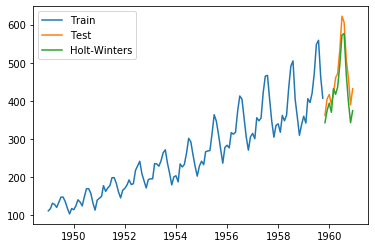

In [53]:
df.index.freq = 'MS'
train, test = df.iloc[:130, 0], df.iloc[130:, 0]  #1959-10-01 #1959-11-01
model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=12).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best');

In [54]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mean_squared_error(test, pred)
model_eval(test, pred)

Mean Absolute Error: 36.243
Mean Squared Error: 469.221
Root Mean Squared Error: 38.912
Mean absolute percentage error: 7.857
Scaled Mean absolute percentage error: 8.225
Mean frequency error: 434.814
Normalised mean squared error: 0.24
Theil_u_statistic: 0.0


In [1]:
model1 = ExponentialSmoothing(df.iloc[:, 0], seasonal='mul', seasonal_periods=12).fit()
pred = model1.foe(6)

In [62]:
model1.forecast(2)

1961-01-01    438.239961
1961-02-01    409.808001
Freq: MS, dtype: float64

In [63]:
filename = 'outputs/ap_ts_model.pkl'
joblib.dump(model1, filename)

['outputs/ap_ts_model.pkl']

In [26]:
# model.slope

In [64]:
run.log('Intercept :', model.sse)
run.log('Slope :', model.slope[0])
 
run.log("Experiment end time", str(datetime.datetime.now()))
run.complete()

In [65]:
model = Model.register(model_path = "outputs/ap_ts_model.pkl",
                       model_name = "ap_ts_model",
                       tags = {"key": "1"},
                       description = "Airline Passengers Prediction",
                       workspace = ws)

Registering model ap_ts_model


In [66]:
test.index[-1]

Timestamp('1960-12-01 00:00:00', freq='MS')

In [67]:
filename = 'outputs/ap_ts_model.pkl'
loaded_model = joblib.load(filename)
data = [['1960-01-01', '1960-12-01']]
y = loaded_model.predict(start = data[0][0], end = data[0][1])
print(y)

Month
1960-01-01    411.079046
1960-02-01    388.189614
1960-03-01    454.519818
1960-04-01    425.999754
1960-05-01    459.508449
1960-06-01    528.189254
1960-07-01    610.810408
1960-08-01    619.596681
1960-09-01    499.714798
1960-10-01    436.540051
1960-11-01    388.585348
1960-12-01    425.988462
Freq: MS, dtype: float64


In [4]:
print(run.get_portal_url())

In [69]:
tsenv = CondaDependencies()
tsenv.add_conda_package("scikit-learn")
tsenv.add_conda_package("matplotlib")
tsenv.add_conda_package("statsmodels")

In [70]:
with open("tsenv.yml","w") as f:
    f.write(tsenv.serialize_to_string())
with open("tsenv.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will

# be automatically provisioned for runs with userManagedDependencies=False.


# Details about the Conda environment file format:

# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually


name: project_environment
dependencies:
  # The python interpreter version.

  # Currently Azure ML only supports 3.5.2 and later.

- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.

  - azureml-defaults

- scikit-learn
- matplotlib
- statsmodels
channels:
- conda-forge



In [ ]:
import json
# np.array(json.loads([['42']]))

json.dumps(y.tolist())

In [107]:
%%writefile score.py
 
import json
from sklearn.externals import joblib
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
 
from azureml.core.model import Model
 
def init():
    global model
    # retrieve the path to the model file using the model name
    model_path = Model.get_model_path('ap_ts_model')
    model = joblib.load(model_path)
 
def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    print(data)
    # make prediction
    predi = model.forecast(data)
    return json.dumps(predi.tolist())

Overwriting score.py


In [108]:
%%time
 
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                                  runtime="python", 
                                                  conda_file="tsenv.yml")

Wall time: 999 µs


In [109]:
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "aml",  "method" : "ts"}, 
                                               description='Predict Airline Passengers')

In [111]:
service = Webservice.deploy_from_model(workspace = ws,
                                       name = 'ts-air-passengers3',
                                       deployment_config = aciconfig,
                                       models = [model],
                                       image_config = image_config)

Creating image
Running...........................................................................
Succeeded
Image creation operation finished for image ts-air-passengers3:1, operation "Succeeded"


In [112]:
service.wait_for_deployment(show_output=True)

Running....................
SucceededACI service creation operation finished, operation "Succeeded"


In [113]:
# print(service.get_logs())

In [5]:
print(service.scoring_uri)

In [99]:
# !curl -X POST -H 'Content-Type':'application/json' -d '{data:[['1960-01-01', '1960-12-01']]}' http://xxxxxxxxxxxxxxxx.southeastasia.azurecontainer.io/score

In [ ]:
# Run in the browser

# http://xxxxxxxxxxxxxxxx.southeastasia.azurecontainer.io/score?data=[[45]]


# Output: 
    
# "[185924.79674796748]"

In [116]:
ws.delete()

In [ ]:
  
#!flask/bin/python
from flask import Flask, jsonify
from sklearn.externals import joblib


filename = 'model/sal_model.pkl'

app = Flask(__name__)

@app.route('/')
def index():
    return "Stackoverflow Salary Predictor"

@app.route('/sal/<int:x>', methods=['GET'])
def predict(x):
    loaded_model=joblib.load(filename)
    y=loaded_model.predict([[x]])[0]
    sal=jsonify({'salary': round(y,2)})
    return sal

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=80)

# ===============================================================

In [1]:
from azureml.core import Workspace, Experiment, Run
import math, random, pickle

In [2]:
import datetime
import dateutil.relativedelta

d = datetime.datetime.strptime("2013-05-01", "%Y-%m-%d")
d2 = d - dateutil.relativedelta.relativedelta(months=1)
print(d2)

2013-04-01 00:00:00
